In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)


In [4]:
data = pd.read_csv("./Data/lending_club_loan_two.csv")
data.head()

FileNotFoundError: [Errno 2] No such file or directory: './Data/lending_club_loan_two.csv'

In [ ]:
data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,395754.00,396030.00,358235.00,395495.00
mean,14113.89,13.64,431.85,74203.18,17.38,11.31,0.18,15844.54,53.79,25.41,1.81,0.12
std,8357.44,4.47,250.73,61637.62,18.02,5.14,0.53,20591.84,24.45,11.89,2.15,0.36
min,500.00,5.32,16.08,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
25%,8000.00,10.49,250.33,45000.00,11.28,8.00,0.00,6025.00,35.80,17.00,0.00,0.00
50%,12000.00,13.33,375.43,64000.00,16.91,10.00,0.00,11181.00,54.80,24.00,1.00,0.00
75%,20000.00,16.49,567.30,90000.00,22.98,14.00,0.00,19620.00,72.90,32.00,3.00,0.00
max,40000.00,30.99,1533.81,8706582.00,9999.00,90.00,86.00,1743266.00,892.30,151.00,34.00,8.00


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [ ]:
data['loan_status'].value_counts().hvplot.bar(
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count', 
    width=500, height=350
)

:Bars   [index]   (loan_status)

C:\Users\Aryan shukla\AppData\Local\Temp\ipykernel_9960\435666691.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='viridis')


<Axes: >

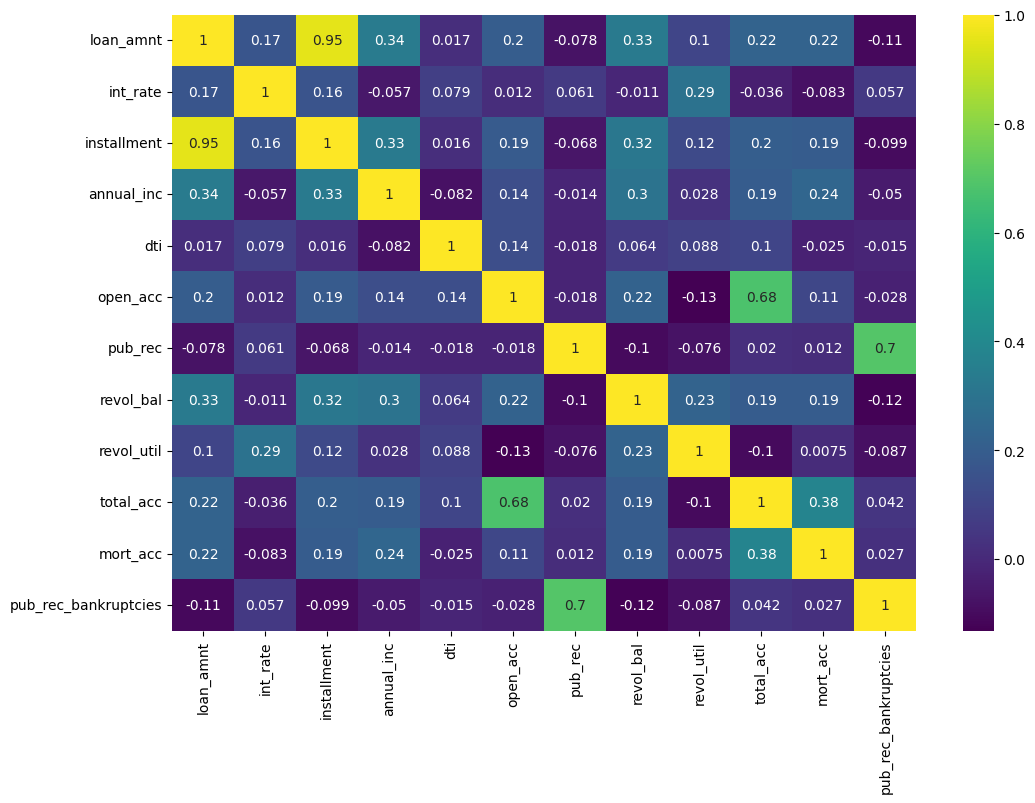

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='viridis')

In [ ]:
installment = data.hvplot.hist(
    y='installment', by='loan_status', subplots=False, 
    width=350, height=400, bins=50, alpha=0.4, 
    title="Installment by Loan Status", 
    xlabel='Installment', ylabel='Counts', legend='top'
)

loan_amnt = data.hvplot.hist(
    y='loan_amnt', by='loan_status', subplots=False, 
    width=350, height=400, bins=30, alpha=0.4, 
    title="Loan Amount by Loan Status", 
    xlabel='Loan Amount', ylabel='Counts', legend='top'
)

installment + loan_amnt

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [installment]   (installment_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [loan_amnt]   (loan_amnt_count)

In [ ]:
loan_amnt_box = data.hvplot.box(
    y='loan_amnt', subplots=True, by='loan_status', width=300, height=350, 
    title="Loan Status by Loan Amount ", xlabel='Loan Status', ylabel='Loan Amount'
)

installment_box = data.hvplot.box(
    y='installment', subplots=True, by='loan_status', width=300, height=350, 
    title="Loan Status by Installment", xlabel='Loan Status', ylabel='Installment'
)

loan_amnt_box + installment_box

:Layout
   .BoxWhisker.I  :BoxWhisker   [loan_status]   (loan_amnt)
   .BoxWhisker.II :BoxWhisker   [loan_status]   (installment)

In [ ]:
data.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.00,15126.30,8505.09,1000.00,8525.00,14000.00,20000.00,40000.00
Fully Paid,318357.00,13866.88,8302.32,500.00,7500.00,12000.00,19225.00,40000.00


In [ ]:
print(f"GRADE unique: {data.grade.unique()}")
print(f"SUB_GRADE unique: {data.sub_grade.unique()}")

GRADE unique: ['B' 'A' 'C' 'E' 'D' 'F' 'G']
SUB_GRADE unique: ['B4' 'B5' 'B3' 'A2' 'C5' 'C3' 'A1' 'B2' 'C1' 'A5' 'E4' 'A4' 'A3' 'D1'
 'C2' 'B1' 'D3' 'D5' 'D2' 'E1' 'E2' 'E5' 'F4' 'E3' 'D4' 'G1' 'F5' 'G2'
 'C4' 'F1' 'F3' 'G5' 'G4' 'F2' 'G3']


In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'grade'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'grade'].value_counts().hvplot.bar() 

(fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Grades', ylabel='Count',
    width=500, height=450, legend_cols=2, legend_position='top_right', xrotation=90
)

:Overlay
   .Bars.Grade.I  :Bars   [index]   (grade)
   .Bars.Grade.II :Bars   [index]   (grade)

C:\Users\Aryan shukla\AppData\Local\Temp\ipykernel_9960\121092049.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


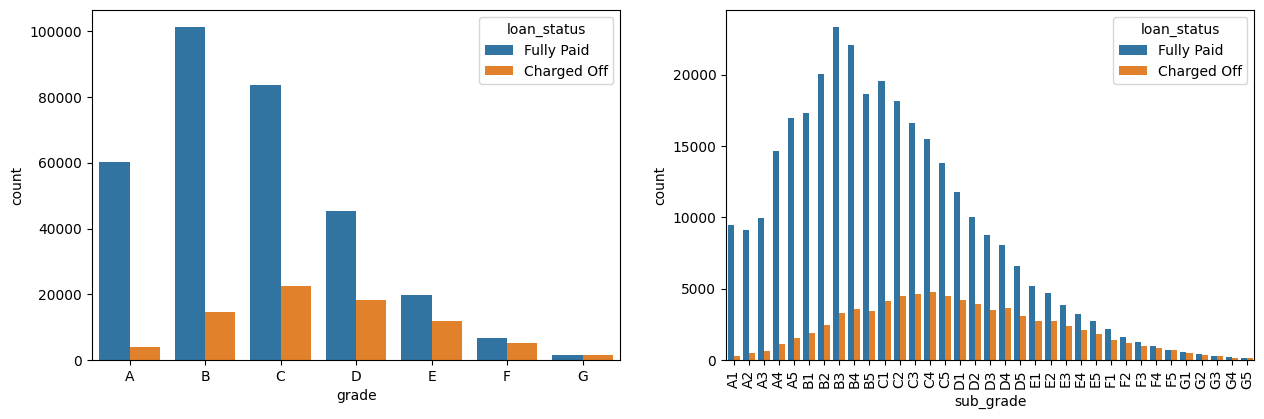

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(data.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(data.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

<Axes: xlabel='sub_grade', ylabel='count'>

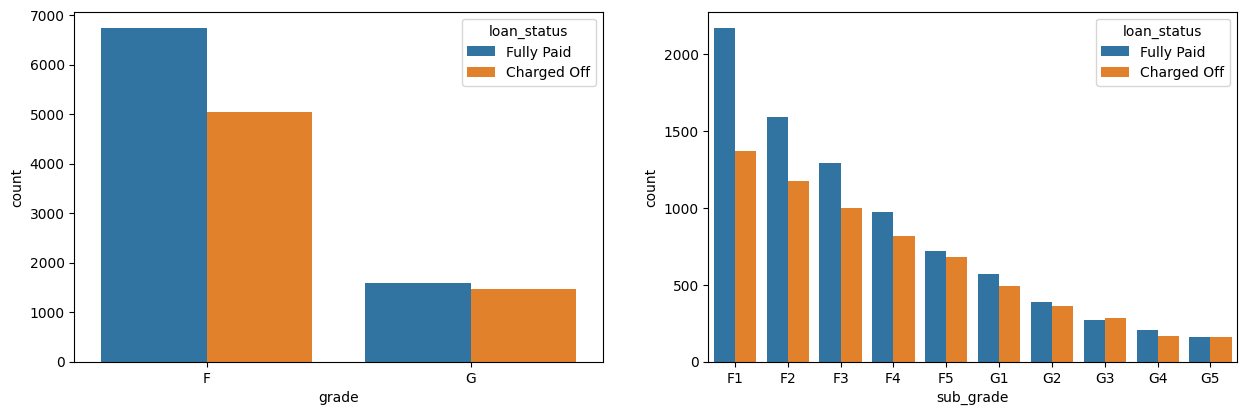

In [ ]:
df = data[(data.grade == 'F') | (data.grade == 'G')]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)

In [ ]:
data['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'home_ownership'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'home_ownership'].value_counts().hvplot.bar()

home_ownership_count = (fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Home Ownership', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=90)

home_ownership = data.home_ownership.value_counts().hvplot.bar(
    title="Loan Status by Grade", xlabel='Home Ownership', ylabel='Count', 
    width=350, height=350, legend='top'
).opts(xrotation=90)

(home_ownership_count + home_ownership)

:Layout
   .Overlay.Home_ownership :Overlay
      .Bars.Home_ownership.I  :Bars   [index]   (home_ownership)
      .Bars.Home_ownership.II :Bars   [index]   (home_ownership)
   .Bars.Home_ownership    :Bars   [index]   (home_ownership)

In [ ]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
data.home_ownership.value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: home_ownership, dtype: int64

C:\Users\Aryan shukla\AppData\Local\Temp\ipykernel_9960\328923337.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'vacation'),
 Text(1, 0, 'debt_consolidation'),
 Text(2, 0, 'credit_card'),
 Text(3, 0, 'home_improvement'),
 Text(4, 0, 'small_business'),
 Text(5, 0, 'major_purchase'),
 Text(6, 0, 'other'),
 Text(7, 0, 'medical'),
 Text(8, 0, 'wedding'),
 Text(9, 0, 'car'),
 Text(10, 0, 'moving'),
 Text(11, 0, 'house'),
 Text(12, 0, 'educational'),
 Text(13, 0, 'renewable_energy')]

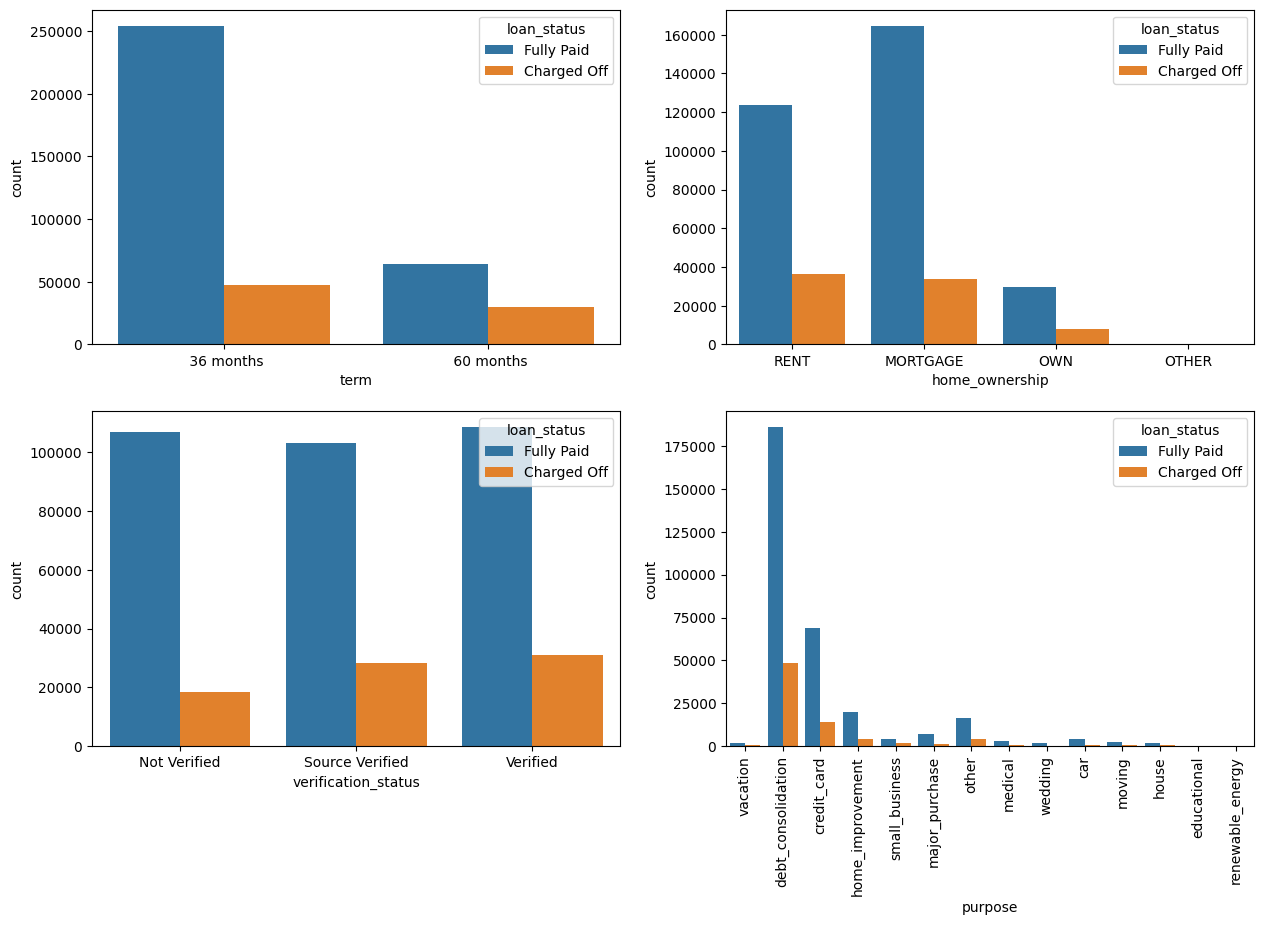

In [ ]:
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [ ]:
data.loc[data['home_ownership']=='OTHER', 'loan_status'].value_counts()


Fully Paid     123
Charged Off     23
Name: loan_status, dtype: int64

In [ ]:
data[data.annual_inc <= 250000].hvplot.hist(
    y='annual_inc', by='loan_status', bins=50, alpha=0.3, width=500, height=400,
    title="Loan Status by Annual Income (<= 250000/Year)", 
    xlabel='Annual Income', ylabel='Loans Counts', legend='top'
).opts(xrotation=45)

:NdOverlay   [loan_status]
   :Histogram   [annual_inc]   (annual_inc_count)

In [ ]:
print((data[data.annual_inc >= 250000].shape[0] / data.shape[0]) * 100)
print((data[data.annual_inc >= 1000000].shape[0] / data.shape[0]) * 100)

1.0294674645860162
0.018937959245511705


In [ ]:
data.loc[data.annual_inc >= 1000000, 'loan_status'].value_counts()

Fully Paid     65
Charged Off    10
Name: loan_status, dtype: int64

In [ ]:
data.loc[data.annual_inc >= 250000, 'loan_status'].value_counts()

Fully Paid     3509
Charged Off     568
Name: loan_status, dtype: int64

In [ ]:
print(data.emp_title.isna().sum())
print(data.emp_title.nunique())

22927
173105


In [ ]:
data['emp_title'].value_counts()[:20]

Teacher                     4389
Manager                     4250
Registered Nurse            1856
RN                          1846
Supervisor                  1830
Sales                       1638
Project Manager             1505
Owner                       1410
Driver                      1339
Office Manager              1218
manager                     1145
Director                    1089
General Manager             1074
Engineer                     995
teacher                      962
driver                       882
Vice President               857
Operations Manager           763
Administrative Assistant     756
Accountant                   748
Name: emp_title, dtype: int64

C:\Users\Aryan shukla\AppData\Local\Temp\ipykernel_9960\1777488078.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


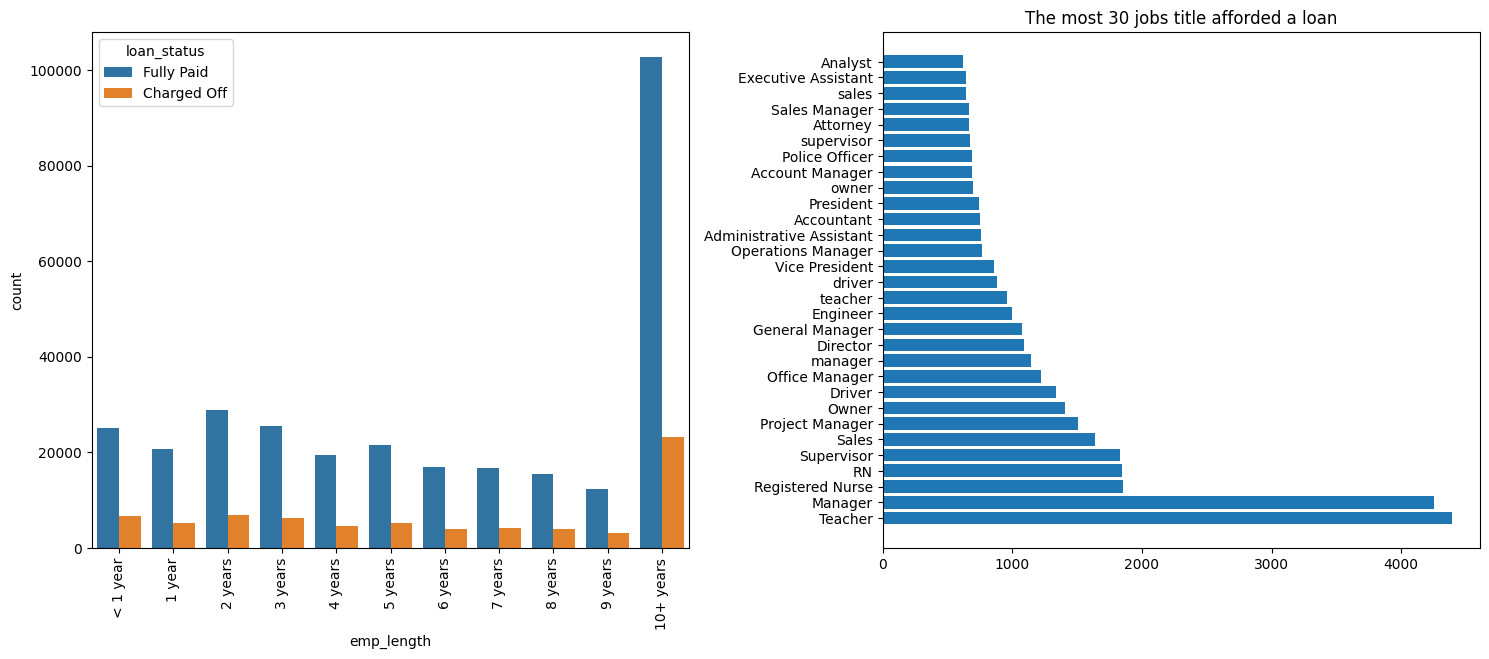

In [ ]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g = sns.countplot(x='emp_length', data=data, hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

plt.subplot(2, 2, 2)
plt.barh(data.emp_title.value_counts()[:30].index, data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a loan")
plt.tight_layout()

In [ ]:
data['earliest_cr_line'].value_counts()

Oct-2000    3017
Aug-2000    2935
Oct-2001    2896
Aug-2001    2884
Nov-2000    2736
            ... 
Jul-1958       1
Nov-1957       1
Jan-1953       1
Jul-1955       1
Aug-1959       1
Name: earliest_cr_line, Length: 684, dtype: int64

In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'issue_d'].hvplot.hist(bins=35) 
charged_off = data.loc[data['loan_status']=='Charged Off', 'issue_d'].hvplot.hist(bins=35)

# fully_paid * charged_off
loan_issue_date = (fully_paid * charged_off).opts(
    title="Loan Status by Loan Issue Date", xlabel='Loan Issue Date', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'earliest_cr_line'].hvplot.hist(bins=35) 
charged_off = data.loc[data['loan_status']=='Charged Off', 'earliest_cr_line'].hvplot.hist(bins=35)

earliest_cr_line = (fully_paid * charged_off).opts(
    title="Loan Status by earliest_cr_line", xlabel='earliest_cr_line', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

loan_issue_date + earliest_cr_line

:Layout
   .Overlay.I  :Overlay
      .Histogram.I  :Histogram   [issue_d]   (issue_d_count)
      .Histogram.II :Histogram   [issue_d]   (issue_d_count)
   .Overlay.II :Overlay
      .Histogram.I  :Histogram   [earliest_cr_line]   (earliest_cr_line_count)
      .Histogram.II :Histogram   [earliest_cr_line]   (earliest_cr_line_count)

In [ ]:
data.title.isna().sum()

1755

In [ ]:
data['title'] = data.title.str.lower()

In [ ]:
data.title.value_counts()[:10]

debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
Name: title, dtype: int64

In [ ]:
data.dti.value_counts()

0.00     313
14.40    310
19.20    302
16.80    301
18.00    300
        ... 
59.18      1
48.37      1
45.71      1
42.38      1
55.53      1
Name: dti, Length: 4262, dtype: int64

In [ ]:
dti = data.hvplot.hist(
    y='dti', bins=50, width=350, height=350, 
    title="dti Distribution", xlabel='dti', ylabel='Count'
)

sub_dti = data[data['dti']<=50].hvplot.hist(
    y='dti', bins=50, width=350, height=350, 
    title="dti (<=30) Distribution", xlabel='dti', ylabel='Count', shared_axes=False
)

dti + sub_dti

:Layout
   .Histogram.I  :Histogram   [dti]   (dti_count)
   .Histogram.II :Histogram   [dti]   (dti_count)

In [ ]:
print(data[data['dti']>=40].shape)

(296, 27)


data.loc[data['dti']>=50, 'loan_status'].value_counts()

In [ ]:
data.loc[data['dti']>=50, 'loan_status'].value_counts()

Fully Paid     26
Charged Off     9
Name: loan_status, dtype: int64

In [ ]:
dti = data[data['dti']<=50].hvplot.hist(
    y='dti', by='loan_status', bins=50, width=300, height=350, 
    title="dti (<=30) Distribution", xlabel='dti', ylabel='Count', 
    alpha=0.3, legend='top'
)

title="Loan Status by The number of open credit lines"

open_acc = data.hvplot.hist(
    y='open_acc', by='loan_status', bins=50, width=300, height=350, 
    title=title, xlabel='The number of open credit lines', ylabel='Count', 
    alpha=0.4, legend='top'
)

title="Loan Status by The total number of credit lines"

total_acc = data.hvplot.hist(
    y='total_acc', by='loan_status', bins=50, width=300, height=350, 
    title=title, xlabel='The total number of credit lines', ylabel='Count', 
    alpha=0.4, legend='top'
)

dti + open_acc + total_acc

:Layout
   .NdOverlay.I   :NdOverlay   [loan_status]
      :Histogram   [dti]   (dti_count)
   .NdOverlay.II  :NdOverlay   [loan_status]
      :Histogram   [open_acc]   (open_acc_count)
   .NdOverlay.III :NdOverlay   [loan_status]
      :Histogram   [total_acc]   (total_acc_count)

In [ ]:
print(data.shape)
print(data[data.open_acc > 40].shape)

(395219, 79)
(215, 79)


In [ ]:
print(data.shape)
print(data[data.total_acc > 80].shape)

(395219, 79)
(266, 79)


In [ ]:
print(data.shape)
print(data[data.revol_util > 120].shape)

(395219, 79)
(27, 79)


In [ ]:
title="Loan Status by Revolving line utilization rate"

revol_util = data.hvplot.hist(
    y='revol_util', by='loan_status', bins=50, width=350, height=400, 
    title=title, xlabel='Revolving line utilization rate', ylabel='Count', 
    alpha=0.4, legend='top'
)

title="Loan Status by Revolving line utilization rate (<120)"

sub_revol_util = data[data.revol_util < 120].hvplot.hist(
    y='revol_util', by='loan_status', bins=50, width=350, height=400, 
    title=title, xlabel='Revolving line utilization rate', ylabel='Count', 
    shared_axes=False, alpha=0.4, legend='top'
)

revol_util + sub_revol_util

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_util]   (revol_util_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_util]   (revol_util_count)

In [ ]:
data[data.revol_util > 200]

,loan_amnt,term,int_rate,installment,annual_inc,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
137211,3500.00,36,12.49,117.08,45000.00,Fully Paid,14.67,1998,2.00,0.00,2677.00,892.30,9.00,0.00,0.00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
print(data.shape)
print(data[data.revol_bal > 250000].shape)

(395219, 79)
(397, 79)


In [ ]:
title = "Loan Status by Total credit revolving balance"

revol_bal = data.hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=350, height=400, 
    title=title, xlabel='Total credit revolving balance', ylabel='Count', 
    alpha=0.4, legend='top'
)

title = "Loan Status by Total credit revolving balance (<250000)"

sub_revol_bal = data[data['revol_bal']<=250000].hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=350, height=400, 
    title=title, xlabel='Total credit revolving balance', ylabel='Count', 
    alpha=0.4, legend='top', shared_axes=False
).opts(xrotation=45)

revol_bal + sub_revol_bal

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (revol_bal_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (revol_bal_count)

In [ ]:
data.loc[data.revol_bal > 250000, 'loan_status'].value_counts()


Fully Paid     351
Charged Off     46
Name: loan_status, dtype: int64

In [ ]:
xlabel = 'Number of derogatory public records'
title = "Loan Status by Number of derogatory public records"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'pub_rec'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'pub_rec'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Pub_rec.I  :Bars   [index]   (pub_rec)
   .Bars.Pub_rec.II :Bars   [index]   (pub_rec)

In [ ]:
data['loan_status'] = data.loan_status.map({'Fully Paid':1, 'Charged Off':0})


In [ ]:
#data preprocessing


In [ ]:
print(f"The Length of the data: {data.shape}")

The Length of the data: (396030, 27)


In [ ]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_title': number of missing values '22927' ==> '5.789%'
'emp_length': number of missing values '18301' ==> '4.621%'
'title': number of missing values '1755' ==> '0.443%'
'revol_util': number of missing values '276' ==> '0.070%'
'mort_acc': number of missing values '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [ ]:
data.emp_title.nunique()

173105

In [ ]:
data.drop('emp_title', axis=1, inplace=True)

In [ ]:
data.emp_length.unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [ ]:
for year in data.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{data[data.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')

10+ years years in this position:
Fully Paid    0.82
Charged Off   0.18
Name: loan_status, dtype: float64
4 years years in this position:
Fully Paid    0.81
Charged Off   0.19
Name: loan_status, dtype: float64
< 1 year years in this position:
Fully Paid    0.79
Charged Off   0.21
Name: loan_status, dtype: float64
6 years years in this position:
Fully Paid    0.81
Charged Off   0.19
Name: loan_status, dtype: float64
9 years years in this position:
Fully Paid    0.80
Charged Off   0.20
Name: loan_status, dtype: float64
2 years years in this position:
Fully Paid    0.81
Charged Off   0.19
Name: loan_status, dtype: float64
3 years years in this position:
Fully Paid    0.80
Charged Off   0.20
Name: loan_status, dtype: float64
8 years years in this position:
Fully Paid    0.80
Charged Off   0.20
Name: loan_status, dtype: float64
7 years years in this position:
Fully Paid    0.81
Charged Off   0.19
Name: loan_status, dtype: float64
5 years years in this position:
Fully Paid    0.81
Charged Of

In [ ]:
data.drop('emp_length', axis=1, inplace=True)

In [ ]:
data.title.value_counts().head()

debt consolidation         168108
credit card refinancing     51781
home improvement            17117
other                       12993
consolidation                5583
Name: title, dtype: int64

In [ ]:
data.purpose.value_counts().head()


debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
Name: purpose, dtype: int64

In [ ]:
data.drop('title', axis=1, inplace=True)

In [ ]:
data.mort_acc.value_counts()

0.00     139777
1.00      60416
2.00      49948
3.00      38049
4.00      27887
5.00      18194
6.00      11069
7.00       6052
8.00       3121
9.00       1656
10.00       865
11.00       479
12.00       264
13.00       146
14.00       107
15.00        61
16.00        37
17.00        22
18.00        18
19.00        15
20.00        13
24.00        10
22.00         7
21.00         4
25.00         4
27.00         3
32.00         2
31.00         2
23.00         2
26.00         2
28.00         1
30.00         1
34.00         1
Name: mort_acc, dtype: int64

In [ ]:
data.mort_acc.isna().sum()

37795

In [ ]:
data.corr()['mort_acc'].drop('mort_acc').sort_values().hvplot.barh()

C:\Users\Aryan shukla\AppData\Local\Temp\ipykernel_9960\2852832020.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['mort_acc'].drop('mort_acc').sort_values().hvplot.barh()


:Bars   [index]   (mort_acc)

In [ ]:
total_acc_avg = data.groupby(by='total_acc').mean().mort_acc

C:\Users\Aryan shukla\AppData\Local\Temp\ipykernel_9960\3866828339.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_acc_avg = data.groupby(by='total_acc').mean().mort_acc


In [ ]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [ ]:
data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [ ]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'revol_util': number of missing values '276' ==> '0.070%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(395219, 24)

In [ ]:
print([column for column in data.columns if data[column].dtype == object])

['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'initial_list_status', 'application_type', 'address']


In [ ]:
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [ ]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

In [ ]:
data.term.unique()

array([36, 60], dtype=int64)

In [ ]:
data.drop('grade', axis=1, inplace=True)

In [ ]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 
           'application_type', 'home_ownership']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

In [ ]:
data.address.head()


0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object

In [ ]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [ ]:
data.zip_code.value_counts()


70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: zip_code, dtype: int64

In [ ]:
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)

In [ ]:
data.drop('address', axis=1, inplace=True)

In [ ]:
data.drop('issue_d', axis=1, inplace=True)

In [ ]:
data['earliest_cr_line'] = data.earliest_cr_line.dt.year

In [ ]:
data.earliest_cr_line.nunique()

65

In [ ]:
data.earliest_cr_line.value_counts()

2000    29302
2001    29031
1999    26444
2002    25849
2003    23623
        ...  
1951        3
1950        3
1953        2
1944        1
1948        1
Name: earliest_cr_line, Length: 65, dtype: int64

In [ ]:
w_p = data.loan_status.value_counts()[0] / data.shape[0]
w_n = data.loan_status.value_counts()[1] / data.shape[0]

print(f"Weight of positive values {w_p}")
print(f"Weight of negative values {w_n}")

Weight of positive values 0.8038479931379817
Weight of negative values 0.19615200686201828


In [ ]:
train, test = train_test_split(data, test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

(264796, 79)
(130423, 79)


In [ ]:
print(train[train['dti'] <= 50].shape)
print(train.shape)

(264776, 79)
(264796, 79)


In [ ]:
print(train.shape)
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]
print(train.shape)

(264796, 79)
(262143, 79)


In [ ]:
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

In [ ]:
X_train.dtypes

loan_amnt         float64
term                int64
int_rate          float64
installment       float64
annual_inc        float64
                   ...   
zip_code_30723      uint8
zip_code_48052      uint8
zip_code_70466      uint8
zip_code_86630      uint8
zip_code_93700      uint8
Length: 78, dtype: object

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [ ]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [ ]:
y_train

array([1., 1., 1., ..., 0., 0., 1.], dtype=float32)

In [ ]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [ ]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20

8192/8192 [==============================] - 51s 6ms/step - loss: 0.3083 - AUC: 0.8603 - val_loss: 0.2670 - val_AUC: 0.9002
Epoch 2/20
8192/8192 [==============================] - 49s 6ms/step - loss: 0.2923 - AUC: 0.8766 - val_loss: 0.2639 - val_AUC: 0.9031
Epoch 3/20
8192/8192 [==============================] - 46s 6ms/step - loss: 0.2861 - AUC: 0.8826 - val_loss: 0.2627 - val_AUC: 0.9046
Epoch 4/20
8192/8192 [==============================] - 45s 5ms/step - loss: 0.2835 - AUC: 0.8849 - val_loss: 0.2614 - val_AUC: 0.9050
Epoch 5/20
8192/8192 [==============================] - 46s 6ms/step - loss: 0.2811 - AUC: 0.8872 - val_loss: 0.2611 - val_AUC: 0.9053
Epoch 6/20
8192/8192 [==============================] - 44s 5ms/step - loss: 0.2803 - AUC: 0.8879 - val_loss: 0.2637 - val_AUC: 0.9047
Epoch 7/20
8192/8192 [==============================] - 45s 5ms/step - loss: 0.2783 - AUC: 0.8897 - val_loss: 0.2601 - val_AUC: 0.9054
Epoch 8/20
8192/8192 [==============================]

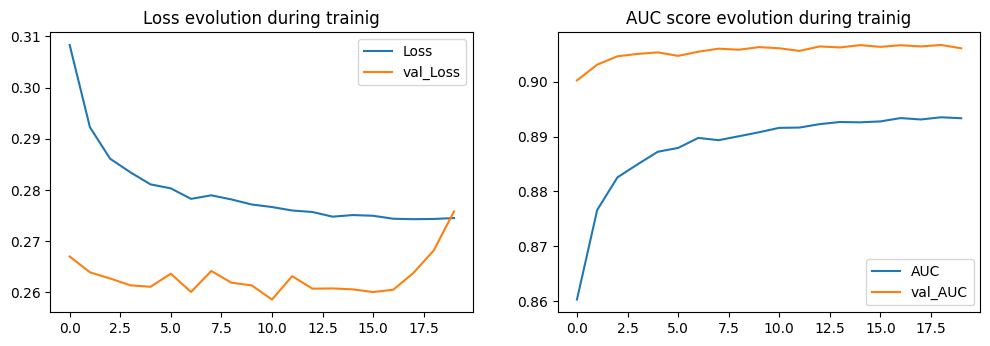

In [ ]:
plot_learning_evolution(r)

In [ ]:
y_train_pred = model.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), train=True)

8192/8192 [==============================] - 19s 2ms/step
Train Result:
Accuracy Score: 88.87%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.94      0.88      0.89       0.91          0.89
recall        0.47      0.99      0.89       0.73          0.89
f1-score      0.62      0.93      0.89       0.78          0.87
support   51665.00 210478.00      0.89  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 24084  27581]
 [  1593 208885]]



In [ ]:
y_test_pred = model.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), train=False)

4076/4076 [==============================] - 10s 2ms/step
Test Result:
Accuracy Score: 88.84%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.93      0.88      0.89       0.91          0.89
recall        0.46      0.99      0.89       0.73          0.89
f1-score      0.62      0.93      0.89       0.78          0.87
support   25480.00 104943.00      0.89  130423.00     130423.00
_______________________________________________
Confusion Matrix: 
 [[ 11846  13634]
 [   922 104021]]



In [ ]:
scores_dict = {
    'ANNs': {
        'Train': roc_auc_score(y_train, model.predict(X_train)),
        'Test': roc_auc_score(y_test, model.predict(X_test)),
    },
}

4076/4076 [==============================] - 9s 2ms/step


In [ ]:
scores_dict

{'ANNs': {'Train': 0.9078619317448655, 'Test': 0.905958658188236}}

In [ ]:
X_train.shape

(262143, 78)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
data

,loan_amnt,term,int_rate,installment,annual_inc,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
0,10000.00,36,11.44,329.48,117000.00,1,26.24,1990,16.00,0.00,36369.00,41.80,25.00,0.00,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
1,8000.00,36,11.99,265.68,65000.00,1,22.05,2004,17.00,0.00,20131.00,53.30,27.00,3.00,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,15600.00,36,10.49,506.97,43057.00,1,12.79,2007,13.00,0.00,11987.00,92.20,26.00,0.00,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
3,7200.00,36,6.49,220.65,54000.00,1,2.60,2006,6.00,0.00,5472.00,21.50,13.00,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,24375.00,60,17.27,609.33,55000.00,0,33.95,1999,13.00,0.00,24584.00,69.80,43.00,1.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.00,60,10.99,217.38,40000.00,1,15.63,2004,6.00,0.00,1990.00,34.30,23.00,0.00,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
396026,21000.00,36,12.29,700.42,110000.00,1,21.45,2006,6.00,0.00,43263.00,95.70,8.00,1.00,0.00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
396027,5000.00,36,9.99,161.32,56500.00,1,17.56,1997,15.00,0.00,32704.00,66.90,23.00,0.00,0.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
396028,21000.00,60,15.31,503.02,64000.00,1,15.88,1990,9.00,0.00,15704.00,53.80,20.00,5.00,0.00,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
import pickle

In [ ]:
filename = 'NN_model.pkl'
pickle.dump(model, open(filename, 'wb'))